# Coursework: Age regression from brain MRI

Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented all approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings.

#### Read the text descriptions and the provided code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.

### Running on Colab or Azure

In [1]:
! pip install SimpleITK==1.2.2 
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

# data directory
data_dir = 'data/brain_age/'

     |████████████████████████████████| 42.5MB 72kB/s 
--2020-02-29 14:07:46--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 900391705 (859M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 858.68M  33.2MB/s    in 27s     

2020-02-29 14:08:13 (32.2 MB/s) - ‘brainage-data.zip’ saved [900391705/900391705]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/greymatter/
  inflating: data/brain_age/greymatter/wc1sub-CC110033_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110037_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110045_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110056_T1w.nii.gz  
  inflating: data/brain_age/gr

### Running on DoC lab machines

In [0]:
# # data directory
# data_dir = '/vol/lab/course/416/data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [3]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

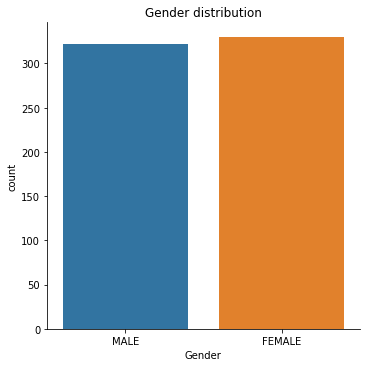

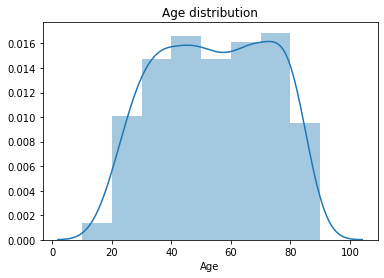

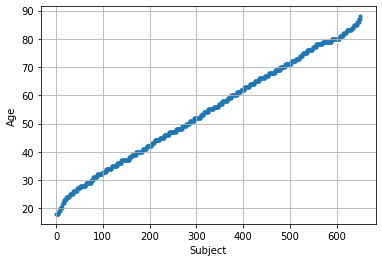

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(np.sort(meta_data['age']), bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])), np.sort(meta_data['age']), marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [0]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


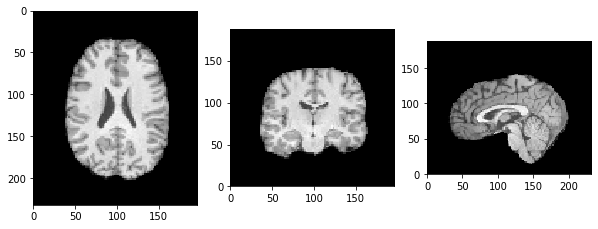

Brain mask (used in part A)


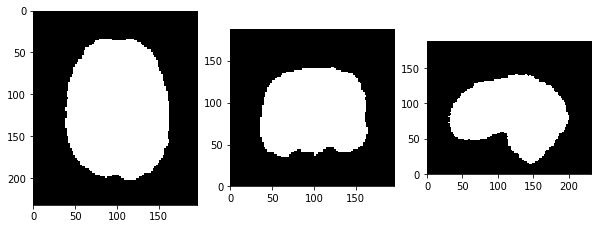

Spatially normalised grey matter maps (used in part B and C)


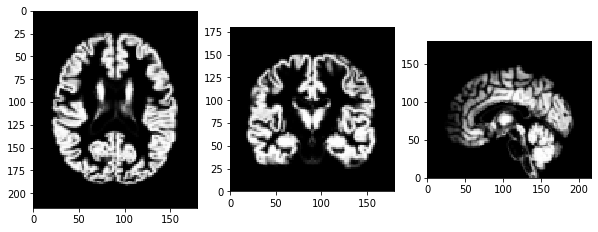

In [6]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is on your VM. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal.

#### Imports

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from scipy.spatial.distance import dice

#### Data Helpers

In [0]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [9]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [0]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 50
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [0]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [12]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
# dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


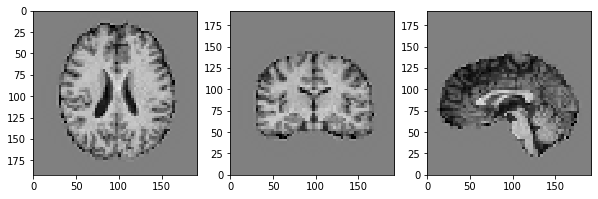

Segmentation


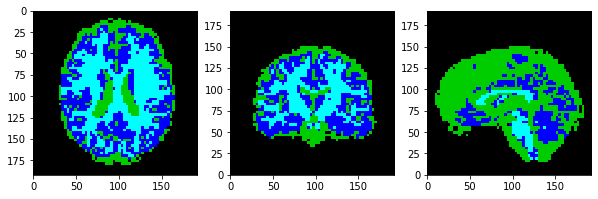

Mask


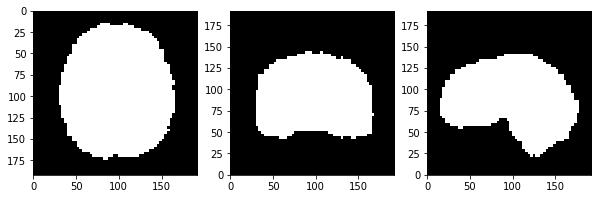

In [13]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [0]:
from collections import OrderedDict

########################################
# BUILD A BETTER MODEL HERE
########################################

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(6, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 120, kernel_size=3, padding=1)
        self.conv4 = nn.Conv3d(120, 84, kernel_size=3, padding=1)
        self.conv5 = nn.Conv3d(84, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return F.log_softmax(x, dim=1)

In [0]:
# class Modified3DUNet(nn.Module):
#     def __init__(self, num_classes, in_channels=1, base_n_filter = 8):
#       super(Modified3DUNet, self).__init__()
#       self.in_channels = in_channels
#       self.num_classes = num_classes
#       self.base_n_filter = base_n_filter

#       self.lrelu = nn.LeakyReLU()
#       self.dropout3d = nn.Dropout3d(p=0.6)
#       self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
#       self.softmax = nn.Softmax(dim=1)

#       # Level 1 context pathway
#       self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
#       self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
#       self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
#       self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

#       # Level 2 context pathway
#       self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter*2, kernel_size=3, stride=2, padding=1, bias=False)
#       self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
#       self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter*2)

#       # Level 3 context pathway
#       self.conv3d_c3 = nn.Conv3d(self.base_n_filter*2, self.base_n_filter*4, kernel_size=3, stride=2, padding=1, bias=False)
#       self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
#       self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter*4)

#       # Level 4 context pathway
#       self.conv3d_c4 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*8, kernel_size=3, stride=2, padding=1, bias=False)
#       self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
#       self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter*8)

#       # Level 5 context pathway, level 0 localization pathway
#       self.conv3d_c5 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*16, kernel_size=3, stride=2, padding=1, bias=False)
#       self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
#       self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*8)

#       self.conv3d_l0 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*8, kernel_size = 1, stride=1, padding=0, bias=False)
#       self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter*8)

#       # Level 1 localization pathway
#       self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*16)
#       self.conv3d_l1 = nn.Conv3d(self.base_n_filter*16, self.base_n_filter*8, kernel_size=1, stride=1, padding=0, bias=False)
#       self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*4)

#       # Level 2 localization pathway
#       self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*8)
#       self.conv3d_l2 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*4, kernel_size=1, stride=1, padding=0, bias=False)
#       self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*2)

#       # Level 3 localization pathway
#       self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*4)
#       self.conv3d_l3 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*2, kernel_size=1, stride=1, padding=0, bias=False)
#       self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter)

#       # Level 4 localization pathway
#       self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter*2)
#       self.conv3d_l4 = nn.Conv3d(self.base_n_filter*2, self.num_classes, kernel_size=1, stride=1, padding=0, bias=False)

#       self.ds2_1x1_conv3d = nn.Conv3d(self.base_n_filter*8, self.num_classes, kernel_size=1, stride=1, padding=0, bias=False)
#       self.ds3_1x1_conv3d = nn.Conv3d(self.base_n_filter*4, self.num_classes, kernel_size=1, stride=1, padding=0, bias=False)


#     def conv_norm_lrelu(self, feat_in, feat_out):
#       return nn.Sequential(
#         nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
#         nn.InstanceNorm3d(feat_out),
#         nn.LeakyReLU())

#     def norm_lrelu_conv(self, feat_in, feat_out):
#       return nn.Sequential(
#         nn.InstanceNorm3d(feat_in),
#         nn.LeakyReLU(),
#         nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

#     def lrelu_conv(self, feat_in, feat_out):
#       return nn.Sequential(
#         nn.LeakyReLU(),
#         nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

#     def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
#       return nn.Sequential(
#         nn.InstanceNorm3d(feat_in),
#         nn.LeakyReLU(),
#         nn.Upsample(scale_factor=2, mode='nearest'),
#         # should be feat_in*2 or feat_in
#         nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
#         nn.InstanceNorm3d(feat_out),
#         nn.LeakyReLU())

#     def forward(self, x):
#       #  Level 1 context pathway
#       out = self.conv3d_c1_1(x)
#       residual_1 = out
#       out = self.lrelu(out)
#       out = self.conv3d_c1_2(out)
#       out = self.dropout3d(out)
#       out = self.lrelu_conv_c1(out)
#       # Element Wise Summation
#       out += residual_1
#       context_1 = self.lrelu(out)
#       out = self.inorm3d_c1(out)
#       out = self.lrelu(out)

#       # Level 2 context pathway
#       out = self.conv3d_c2(out)
#       residual_2 = out
#       out = self.norm_lrelu_conv_c2(out)
#       out = self.dropout3d(out)
#       out = self.norm_lrelu_conv_c2(out)
#       out += residual_2
#       out = self.inorm3d_c2(out)
#       out = self.lrelu(out)
#       context_2 = out

#       # Level 3 context pathway
#       out = self.conv3d_c3(out)
#       residual_3 = out
#       out = self.norm_lrelu_conv_c3(out)
#       out = self.dropout3d(out)
#       out = self.norm_lrelu_conv_c3(out)
#       out += residual_3
#       out = self.inorm3d_c3(out)
#       out = self.lrelu(out)
#       context_3 = out

#       # Level 4 context pathway
#       out = self.conv3d_c4(out)
#       residual_4 = out
#       out = self.norm_lrelu_conv_c4(out)
#       out = self.dropout3d(out)
#       out = self.norm_lrelu_conv_c4(out)
#       out += residual_4
#       out = self.inorm3d_c4(out)
#       out = self.lrelu(out)
#       context_4 = out

#       # Level 5
#       out = self.conv3d_c5(out)
#       residual_5 = out
#       out = self.norm_lrelu_conv_c5(out)
#       out = self.dropout3d(out)
#       out = self.norm_lrelu_conv_c5(out)
#       out += residual_5
#       out = self.norm_lrelu_upscale_conv_norm_lrelu_l0(out)

#       out = self.conv3d_l0(out)
#       out = self.inorm3d_l0(out)
#       out = self.lrelu(out)

#       # Level 1 localization pathway
#       out = torch.cat([out, context_4], dim=1)
#       out = self.conv_norm_lrelu_l1(out)
#       out = self.conv3d_l1(out)
#       out = self.norm_lrelu_upscale_conv_norm_lrelu_l1(out)

#       # Level 2 localization pathway
#       out = torch.cat([out, context_3], dim=1)
#       out = self.conv_norm_lrelu_l2(out)
#       ds2 = out
#       out = self.conv3d_l2(out)
#       out = self.norm_lrelu_upscale_conv_norm_lrelu_l2(out)

#       # Level 3 localization pathway
#       out = torch.cat([out, context_2], dim=1)
#       out = self.conv_norm_lrelu_l3(out)
#       ds3 = out
#       out = self.conv3d_l3(out)
#       out = self.norm_lrelu_upscale_conv_norm_lrelu_l3(out)

#       # Level 4 localization pathway
#       out = torch.cat([out, context_1], dim=1)
#       out = self.conv_norm_lrelu_l4(out)
#       out_pred = self.conv3d_l4(out)

#       ds2_1x1_conv = self.ds2_1x1_conv3d(ds2)
#       ds1_ds2_sum_upscale = self.upsacle(ds2_1x1_conv)
#       ds3_1x1_conv = self.ds3_1x1_conv3d(ds3)
#       ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
#       ds1_ds2_sum_upscale_ds3_sum_upscale = self.upsacle(ds1_ds2_sum_upscale_ds3_sum)

#       out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale
#       seg_layer = out
#       out = out.permute(0, 2, 3, 4, 1).contiguous().view(-1, self.num_classes)
#       print(out.size())
#       out = out.view(-1, self.num_classes)
#       out = self.softmax(out)
#       return out, seg_layer

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor precision, recall and Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.280987
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.245360
+ VALIDATE 	 Avg Dice Similarity - CSF: 0.5375814412257267, GM: 0.615821034290976, WM: 0.6847433312766107
+ VALIDATE 	 Avg Recall Score - CSF: 0.5571634264854881, GM: 0.6208741629653549, WM: 0.64543998028018
+ VALIDATE 	 Avg Precision Score - CSF: 0.527318049861916, GM: 0.6120643984162208, WM: 0.7306291361783416


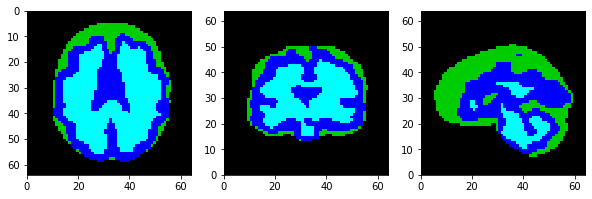

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.207444
+ TRAINING 	Epoch: 3 	Loss: 0.233481
+ TRAINING 	Epoch: 4 	Loss: 0.178362
+ TRAINING 	Epoch: 5 	Loss: 0.167378
+ TRAINING 	Epoch: 6 	Loss: 0.196939
+ TRAINING 	Epoch: 7 	Loss: 0.165120
+ TRAINING 	Epoch: 8 	Loss: 0.152568
+ TRAINING 	Epoch: 9 	Loss: 0.157734
+ TRAINING 	Epoch: 10 	Loss: 0.159056
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.138983
+ VALIDATE 	 Avg Dice Similarity - CSF: 0.7085732750712854, GM: 0.7694229910253819, WM: 0.8311198944842653
+ VALIDATE 	 Avg Recall Score - CSF: 0.6642921391784646, GM: 0.8109186638335781, WM: 0.8391131722311412
+ VALIDATE 	 Avg Precision Score - CSF: 0.7669102037567899, GM: 0.7320564460360852, WM: 0.8241556288623881


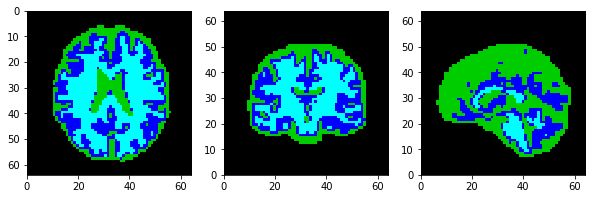

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.142992
+ TRAINING 	Epoch: 12 	Loss: 0.106964
+ TRAINING 	Epoch: 13 	Loss: 0.145159
+ TRAINING 	Epoch: 14 	Loss: 0.113401
+ TRAINING 	Epoch: 15 	Loss: 0.139509
+ TRAINING 	Epoch: 16 	Loss: 0.138903
+ TRAINING 	Epoch: 17 	Loss: 0.128892
+ TRAINING 	Epoch: 18 	Loss: 0.129725
+ TRAINING 	Epoch: 19 	Loss: 0.140359
+ TRAINING 	Epoch: 20 	Loss: 0.126192
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.126617
+ VALIDATE 	 Avg Dice Similarity - CSF: 0.741162453681859, GM: 0.8252651447750594, WM: 0.8507394811783702
+ VALIDATE 	 Avg Recall Score - CSF: 0.6867747441271301, GM: 0.8145889807106036, WM: 0.8930859827932711
+ VALIDATE 	 Avg Precision Score - CSF: 0.8130087716699643, GM: 0.8363708638788472, WM: 0.8128821256547214


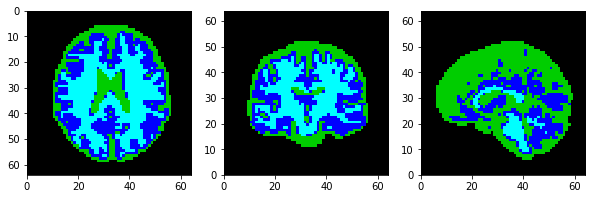

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.116846
+ TRAINING 	Epoch: 22 	Loss: 0.117345
+ TRAINING 	Epoch: 23 	Loss: 0.152212
+ TRAINING 	Epoch: 24 	Loss: 0.126578
+ TRAINING 	Epoch: 25 	Loss: 0.129184
+ TRAINING 	Epoch: 26 	Loss: 0.106657
+ TRAINING 	Epoch: 27 	Loss: 0.110958
+ TRAINING 	Epoch: 28 	Loss: 0.094849
+ TRAINING 	Epoch: 29 	Loss: 0.115428
+ TRAINING 	Epoch: 30 	Loss: 0.184896
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.115569
+ VALIDATE 	 Avg Dice Similarity - CSF: 0.750592449361968, GM: 0.8195075778606032, WM: 0.8679292755261413
+ VALIDATE 	 Avg Recall Score - CSF: 0.713419062281621, GM: 0.8632145524301013, WM: 0.873225979669375
+ VALIDATE 	 Avg Precision Score - CSF: 0.7990956772415926, GM: 0.7801209106220977, WM: 0.8633574514585861


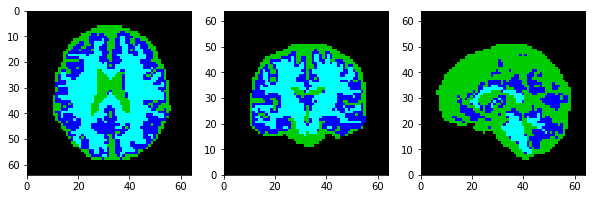

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.118829
+ TRAINING 	Epoch: 32 	Loss: 0.125862
+ TRAINING 	Epoch: 33 	Loss: 0.098570
+ TRAINING 	Epoch: 34 	Loss: 0.177410
+ TRAINING 	Epoch: 35 	Loss: 0.099933
+ TRAINING 	Epoch: 36 	Loss: 0.151596
+ TRAINING 	Epoch: 37 	Loss: 0.108902
+ TRAINING 	Epoch: 38 	Loss: 0.154828
+ TRAINING 	Epoch: 39 	Loss: 0.103244
+ TRAINING 	Epoch: 40 	Loss: 0.107747
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.104692
+ VALIDATE 	 Avg Dice Similarity - CSF: 0.7684260038911362, GM: 0.8541651630031971, WM: 0.875701489837863
+ VALIDATE 	 Avg Recall Score - CSF: 0.7548259587904753, GM: 0.8385891258980708, WM: 0.9093822167112803
+ VALIDATE 	 Avg Precision Score - CSF: 0.7892408410177759, GM: 0.8704966625266201, WM: 0.8449436418058891


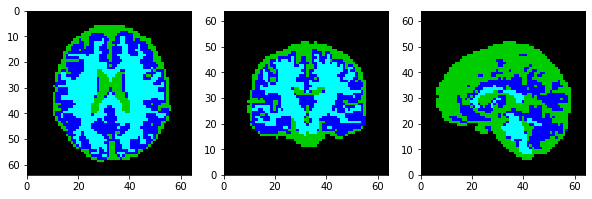

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.105251
+ TRAINING 	Epoch: 42 	Loss: 0.097347
+ TRAINING 	Epoch: 43 	Loss: 0.116994
+ TRAINING 	Epoch: 44 	Loss: 0.091886
+ TRAINING 	Epoch: 45 	Loss: 0.112256
+ TRAINING 	Epoch: 46 	Loss: 0.119708
+ TRAINING 	Epoch: 47 	Loss: 0.095531
+ TRAINING 	Epoch: 48 	Loss: 0.127526
+ TRAINING 	Epoch: 49 	Loss: 0.095194
+ TRAINING 	Epoch: 50 	Loss: 0.086964
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.102175
+ VALIDATE 	 Avg Dice Similarity - CSF: 0.7548677015231938, GM: 0.8599995800282588, WM: 0.8845976118661717
+ VALIDATE 	 Avg Recall Score - CSF: 0.7937092602142676, GM: 0.825299070855851, WM: 0.9006444174595536
+ VALIDATE 	 Avg Precision Score - CSF: 0.725036713569353, GM: 0.8979224346685116, WM: 0.8696498206290709


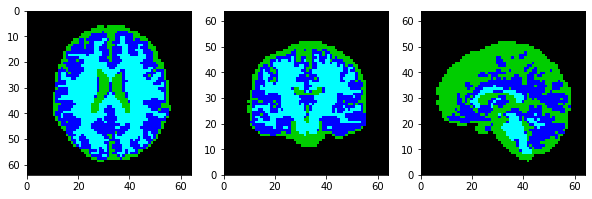

--------------------------------------------------

Finished TRAINING.


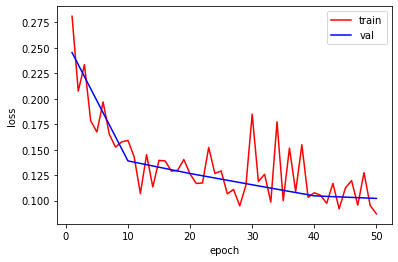

In [16]:
from sklearn.metrics import precision_score, recall_score

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = SimpleNet3D(num_classes=num_classes).to(device)
# model = Modified3DUNet(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []

def avg_tissue_scores_str(scores, n_samples):
    tissue_names = {1: "CSF", 2: "GM", 3: "WM"}
    avg_scores = tuple(f"{tissue_names.get(k)}: {v / n_samples}" for k, v in scores.items())
    return ", ".join(avg_scores)

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        
        dice_per_tissue = {1:0, 2:0, 3:0}
        recall_per_tissue = {1:0, 2:0, 3:0}
        precision_per_tissue = {1:0, 2:0, 3:0}
        num_samples = 0
        precision = 0
        recall = 0
        
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)


                pred = torch.argmax(prd, dim=1)

                for tissue_idx in range(1,4):
                    # dice() computes dice dissimilarity
                    pred_seg = (pred.cpu()[0] == tissue_idx).view(-1,)
                    ref_seg = (seg.cpu()[0, 0] == tissue_idx).view(-1,)
                    dice_per_tissue[tissue_idx] += (1 - dice(ref_seg, pred_seg))
                pred_flat = pred.cpu().view(-1,)
                ref_flat = seg.cpu().view(-1,)
                recalls = recall_score(pred_flat, ref_flat, average=None)
                precisions = precision_score(pred_flat, ref_flat, average=None)
                for i in range(1, 4):
                    recall_per_tissue[i] += recalls[i]
                    precision_per_tissue[i] += precisions[i]
                num_samples += 1

        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts
        recall /= num_samples
        precision /= num_samples

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        dice_scores_str = avg_tissue_scores_str(dice_per_tissue, num_samples)
        precision_scores_str = avg_tissue_scores_str(precision_per_tissue, num_samples)
        recall_scores_str = avg_tissue_scores_str(recall_per_tissue, num_samples)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        print(f'+ VALIDATE \t Avg Dice Similarity - {dice_scores_str}')
        print(f'+ VALIDATE \t Avg Recall Score - {recall_scores_str}')
        print(f'+ VALIDATE \t Avg Precision Score - {precision_scores_str}')
        
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [17]:
# LOAD VALIDATION DATASET 
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')

# LOAD TEST DATASET
# meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')

ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:27<00:00,  5.56it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


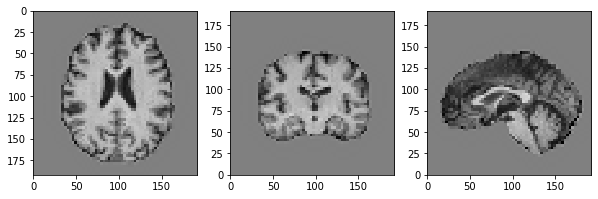

Segmentation


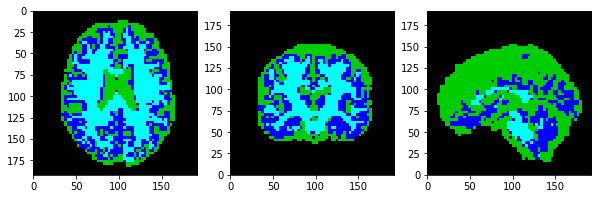

Mask


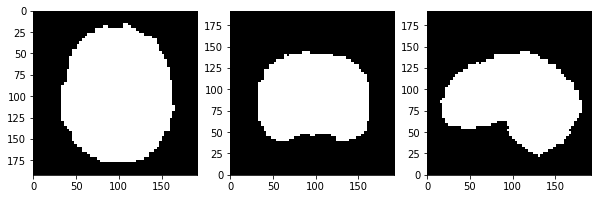

In [18]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly others) to evaluate the segmentation performance.**

START TESTING...
--------------------------------------------------
+ TEST 	 Image 1
+ TEST 	 Dice Similarity - CSF: 0.7909569526169092, GM: 0.8427800561191452, WM: 0.8969469356039758
+ TEST 	 Recall Score - CSF: 0.8722677595628415, GM: 0.7962396508829886, WM: 0.896685655100984
+ TEST 	 Precision Score - CSF: 0.7235127478753541, GM: 0.8950988033561047, WM: 0.8972083684176436
--------------------------------------------------
+ TEST 	 Image 2
+ TEST 	 Dice Similarity - CSF: 0.7403167924761787, GM: 0.8253354507583603, WM: 0.871263793165018
+ TEST 	 Recall Score - CSF: 0.8872163725344802, GM: 0.7577230275113046, WM: 0.9049703264094956
+ TEST 	 Precision Score - CSF: 0.6351523516296846, GM: 0.9061963004144344, WM: 0.8399779659849893
--------------------------------------------------
+ TEST 	 Image 3
+ TEST 	 Dice Similarity - CSF: 0.7183501904636805, GM: 0.7737760834670947, WM: 0.881267302368502
+ TEST 	 Recall Score - CSF: 0.9150659259755036, GM: 0.6961505483099418, WM: 0.8427709957346669

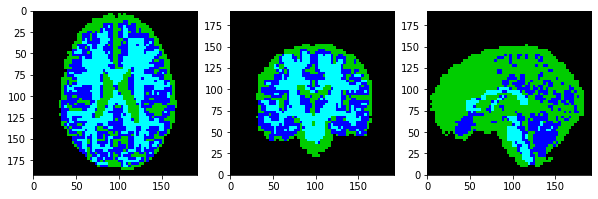

Predicted segmentation


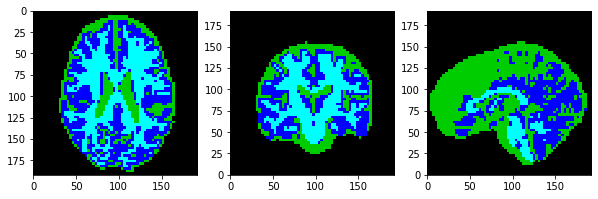


Finished TESTING.


In [19]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
# dice_test = 0
# precision_test = 0
# recall_test = 0

tissues_dice = {1: [], 2: [], 3: []}
tissues_prec = {1: 0, 2: 0, 3: 0}
tissues_recall = {1: 0, 2: 0, 3: 0}

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)       
        
        prd = torch.argmax(prd, dim=1)

        pred_flat = prd.cpu().view(-1,)
        ref_flat = seg.cpu().view(-1,)
        recalls = recall_score(pred_flat, ref_flat, average=None, labels=[1,2,3])
        precisions = precision_score(pred_flat, ref_flat, average=None, labels=[1,2,3])

        precision_scores = {}
        recall_scores = {}
        dice_scores = {}
        for tissue_idx in range(1,4):
            # dice() computes dice dissimilarity
            pred_seg = (prd.cpu()[0] == tissue_idx).view(-1,)
            dice_seg = (seg.cpu()[0, 0] == tissue_idx).view(-1,)
            dice_score = 1 - dice(dice_seg, pred_seg)
            tissues_dice[tissue_idx].append(dice_score)
            tissues_prec[tissue_idx] += precisions[tissue_idx - 1]
            tissues_recall[tissue_idx] += precisions[tissue_idx - 1]

            precision_scores[tissue_idx] = precisions[tissue_idx - 1]
            recall_scores[tissue_idx] = recalls[tissue_idx - 1]
            dice_scores[tissue_idx] = dice_score
        
        dice_scores_str = avg_tissue_scores_str(dice_scores, n_samples=1)
        precision_scores_str = avg_tissue_scores_str(precision_scores, n_samples=1)
        recall_scores_str = avg_tissue_scores_str(recall_scores, 1)

        print('--------------------------------------------------')
        print(f'+ TEST \t Image {idx_test + 1}')
        print(f'+ TEST \t Dice Similarity - {dice_scores_str}')
        print(f'+ TEST \t Recall Score - {recall_scores_str}')
        print(f'+ TEST \t Precision Score - {precision_scores_str}')


        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.int64))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))

        # ref = sample['seg']

        # overlap_measures_filter.Execute(prediction, ref)
        # dice_test += overlap_measures_filter.GetDiceCoefficient()
        # print('+ TESTING \tCurrent DSC: ' + str(overlap_measures_filter.GetDiceCoefficient()) )

        # predictions = sitk.GetArrayFromImage(prediction)
        # predictions = predictions.reshape(-1,)

        # refs = sitk.GetArrayFromImage(ref)
        # refs = refs.reshape(-1,)

        # precision_test += precision_score(predictions, refs)
        # recall_test += recall_score(predictions, refs)

        idx_test += 1
        

# TODO: Fix this to print metrics per tissue
loss_test /= sum_pts
dice_dict = {k: sum(v) for k, v in tissues_dice.items()}

dice_test = avg_tissue_scores_str(dice_dict, idx_test)
precision_test = avg_tissue_scores_str(tissues_prec, idx_test)
recall_test = avg_tissue_scores_str(tissues_recall, idx_test)

print('\n\n+ TESTING \t Loss: {:.6f}'.format(loss_test))
print('+ TESTING \t Avg Dice Score: ' + dice_test) 
print('+ TESTING \t Avg Precision Score: ' + precision_test)
print('+ TESTING \t Avg Recall Score: ' + recall_test)

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

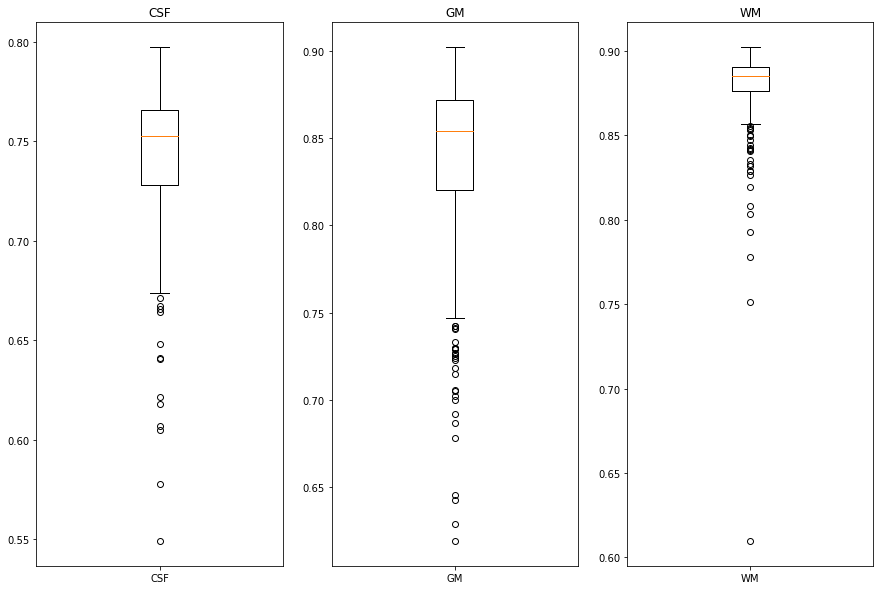

In [20]:
# box plots
tissues = {1: "CSF", 2: "GM", 3: "WM"}
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
for tissue_idx, dice_scores in tissues_dice.items():
    ax[tissue_idx - 1].boxplot(dice_scores, labels=[tissues[tissue_idx]])
    ax[tissue_idx - 1].set_title(tissues[tissue_idx])

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [0]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

def get_volumes(meta_file="meta_data_reg_train.csv"):
    # USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
    seg_dir = './output/pred/'
    meta_dir = 'meta/'

    # USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
    # seg_dir = data_dir + 'segs_refs/'

    # LOAD VALIDATION DATASET
    # meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')

    # LOAD TEST DATASET
    meta_data_reg_data = pd.read_csv(f"{data_dir}{meta_dir}{meta_file}")

    ids_reg_train = list(meta_data_reg_data['subject_id'])
    files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

    # THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
    vols = np.zeros((3,len(files_reg_seg_train)))

    for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
        
        seg_filename = files_reg_seg_train[idx]
        
        if os.path.exists(seg_filename):
            seg = sitk.ReadImage(seg_filename)
            
            ########################################
            # ADD YOUR CODE HERE
            ########################################

            img_arr = sitk.GetArrayFromImage(seg)
            _, counts = np.unique(img_arr, return_counts=True)
            # ignore background counts
            vols[:, idx] = counts[1:]
    return vols, meta_data_reg_data

In [22]:
# Load validation volumes
val_vols, meta_data_reg_train = get_volumes(meta_file="meta_data_reg_train.csv")

Calculating Features: 100%|██████████| 500/500 [00:05<00:00, 99.40it/s]


Function to plot tissue volumes

Plot features versus age.

In [0]:
def volume_scatter_plot(vols, meta_data_reg, title="Normalised"):  
    plt.scatter(vols[0,:],meta_data_reg['age'], marker='.')
    plt.scatter(vols[1,:],meta_data_reg['age'], marker='.')
    plt.scatter(vols[2,:],meta_data_reg['age'], marker='.')
    plt.grid()
    plt.title(title)
    plt.xlabel('Volume')
    plt.ylabel('Age')
    plt.legend(('CSF','GM','WM'))
    plt.show()

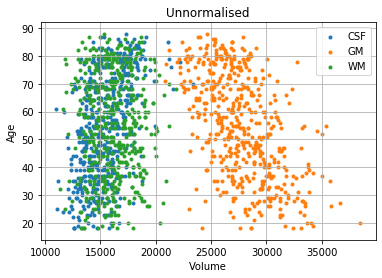

In [24]:
volume_scatter_plot(val_vols, meta_data_reg_train, title="Unnormalised")

In [0]:
def normalise_tissue_volumes(vols):
    ## CALCULATE RELATIVE TISSUE VOLUMES

    vols_normalised = np.zeros(vols.shape)

    ########################################
    # ADD YOUR CODE HERE
    ########################################
    vols_normalised = vols / np.sum(vols, axis=0)

    return vols_normalised

In [0]:
val_vols_normalised = normalise_tissue_volumes(val_vols)

Plot normalised features versus age.

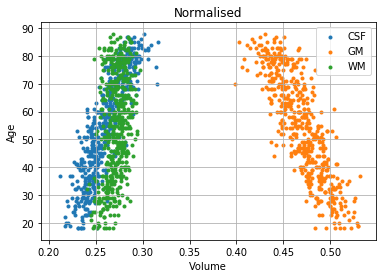

In [27]:
volume_scatter_plot(val_vols_normalised, meta_data_reg_train, title="Normalised")

Final data for age regression

In [28]:
X = val_vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [0]:
from sklearn import linear_model, model_selection, svm
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import (SGDRegressor, LinearRegression, 
                                  OrthogonalMatchingPursuit, BayesianRidge, 
                                  LassoLars, ElasticNet, Lasso, Ridge)
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR

In [0]:
# Visualise the data split to make sure that classes in the dataset are still balanced
def visualize_data_distribution(ages_split, indices):
  meta_data = meta_data_all
  from copy import deepcopy
  meta_data_ = deepcopy(meta_data)
  meta_data_['gender_text'] = meta_data_['gender_text'][indices]
  sns.catplot(x="gender_text", data=meta_data_, kind="count")
  plt.title('Gender distribution')
  plt.xlabel('Gender')
  plt.show()
  sorted_ages_split = np.sort(np.concatenate(ages_split))


  sns.distplot(sorted_ages_split, bins=[10,20,30,40,50,60,70,80,90])
  plt.title('Age distribution')
  plt.xlabel('Age')
  plt.show()

  plt.scatter(range(len(sorted_ages_split)), sorted_ages_split, marker='.')
  plt.grid()
  plt.xlabel('Subject')
  plt.ylabel('Age')
  plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


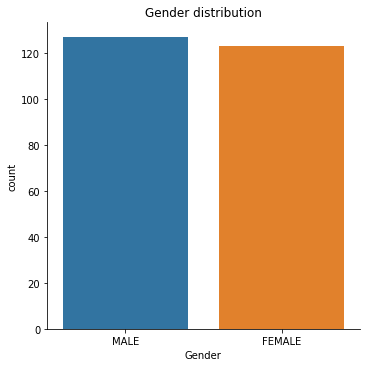

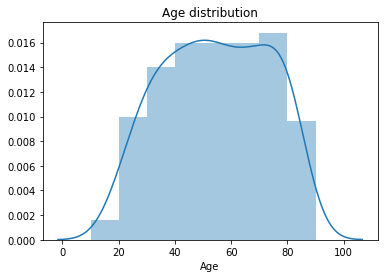

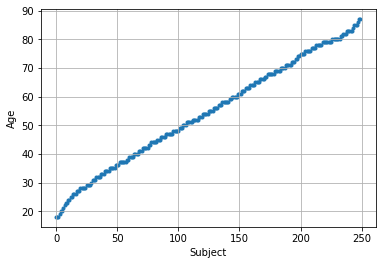

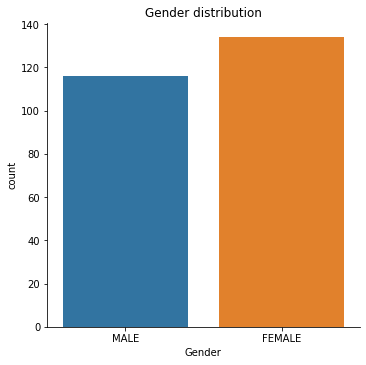

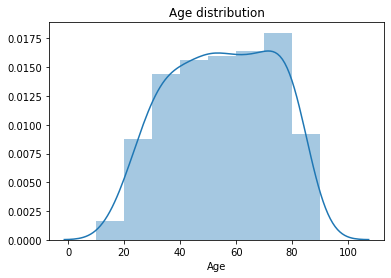

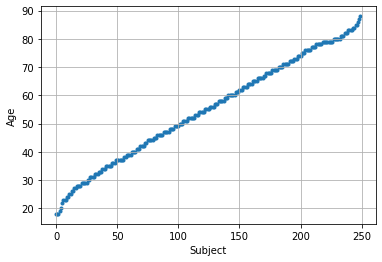

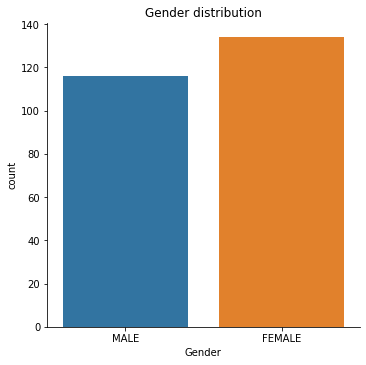

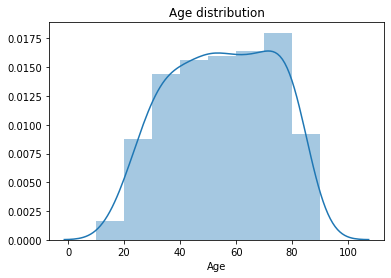

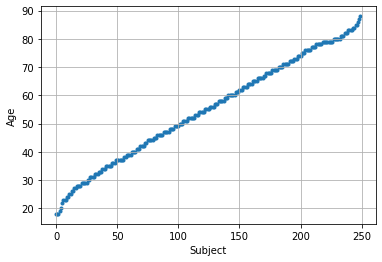

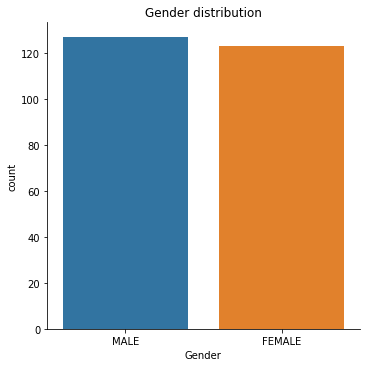

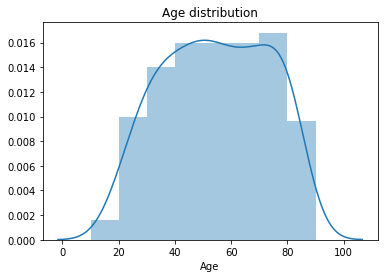

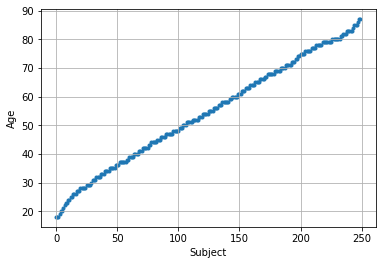

In [78]:
 model = SVR(kernel='linear', C=1)
 skfold = StratifiedKFold(n_splits=2, random_state=1000, shuffle=True)

for train_indexes, test_indexes in skfold.split(X, y):
    model = clone(model, safe=True)

    # print("TRAIN:", train_indexes, "TEST:", test_indexes)
    X_train, X_test = X[train_indexes], X[test_indexes]
    y_train, y_test = y[train_indexes], y[test_indexes]

    visualize_data_distribution(y_train, train_indexes)
    visualize_data_distribution(y_test, test_indexes)

    # print(y_train)

    # model.fit(X_train, y_train)
    # predicted = model.predict(X_test)
    # for j in range(len(test_index)):
    #   predicted_of_models[test_index[j]][i] = predicted[j]

In [30]:
########################################
# ADD YOUR CODE HERE
########################################
clfs = [SVR(kernel='linear', C=1), SGDRegressor(alpha=0.001), 
        Pipeline([('poly', PolynomialFeatures(degree=3)), 
                  ('linear', LinearRegression(fit_intercept=False))]),
        BayesianRidge(), OrthogonalMatchingPursuit(n_nonzero_coefs=1),
        LassoLars(alpha=0.1), ElasticNet(), Lasso(), Ridge(alpha=.5),
        RandomForestRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor()]
scoring = ['r2', 'neg_mean_absolute_error']
skfold = StratifiedKFold(n_splits=2, random_state=1000, shuffle=True)

avg_maes = np.array([])
maes = []

for model in clfs:
    results_skfold = model_selection.cross_validate(model, X, y.squeeze(1), 
                                                    cv=skfold, scoring=scoring, 
                                                    return_estimator=True)
    
    print("\n*****************\n%s\n****************" % model)
    print("R2 score: %s" % str(results_skfold['test_r2']))
    print("Mean absolute error: %s" % str(-results_skfold['test_neg_mean_absolute_error']))
    print("Results: ", results_skfold)

    maes.append(-results_skfold['test_neg_mean_absolute_error'])
    avg_maes = np.append(avg_maes, -np.average(results_skfold['test_neg_mean_absolute_error']))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarn


*****************
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
****************
R2 score: [0.0171162  0.01584102]
Mean absolute error: [15.61767259 15.81496764]
Results:  {'fit_time': array([0.00367427, 0.00310874]), 'score_time': array([0.00125051, 0.00090003]), 'estimator': (SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False), SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)), 'test_r2': array([0.0171162 , 0.01584102]), 'test_neg_mean_absolute_error': array([-15.61767259, -15.81496764])}

*****************
SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss=

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)



*****************
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
****************
R2 score: [0.7281226 0.7200649]
Mean absolute error: [7.65860343 7.7176456 ]
Results:  {'fit_time': array([0.05181575, 0.04578352]), 'score_time': array([0.00130391, 0.00110006]), 'estimator': (GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          

In [31]:
n = 3
print(avg_maes)
top_n_model_indexes = avg_maes.argsort()[:n][::-1]
print("Top n model indexes are:", top_n_model_indexes)

top_n_model_names = []
top_n_model_maes = []
top_n_model_avg_maes = []
print(maes)
for index in top_n_model_indexes:
  top_n_model_names.append(type(clfs[index]).__name__)
  top_n_model_maes.append(maes[index])
  top_n_model_avg_maes.append(avg_maes[index])

print(top_n_model_names)
print(top_n_model_maes)
print(top_n_model_avg_maes)

[15.71632011 14.47938511  7.16428452  7.40921773  7.66192831  7.62288848
 15.852      15.852      12.10783914  7.76718     7.96722     7.68812451]
Top n model indexes are: [5 3 2]
[array([15.61767259, 15.81496764]), array([14.40020714, 14.55856308]), array([7.28146989, 7.04709914]), array([7.34954447, 7.46889098]), array([7.70429366, 7.61956295]), array([7.61596647, 7.62981049]), array([15.756, 15.948]), array([15.756, 15.948]), array([12.09573914, 12.11993913]), array([7.72628, 7.80808]), array([7.84284, 8.0916 ]), array([7.65860343, 7.7176456 ])]
['LassoLars', 'BayesianRidge', 'Pipeline']
[array([7.61596647, 7.62981049]), array([7.34954447, 7.46889098]), array([7.28146989, 7.04709914])]
[7.622888477675692, 7.4092177285118215, 7.164284517441986]


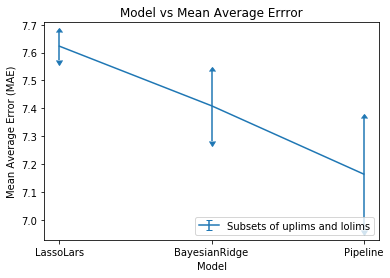

In [32]:
lower_limits = []
upper_limits = []
for i in range(len(top_n_model_maes)):
    lower_limits.append(np.max(top_n_model_maes[i]) - top_n_model_avg_maes[i])
    upper_limits.append(top_n_model_avg_maes[i] - np.min(top_n_model_maes[i]))

yerr = np.linspace(0.05, 0.2, 3)

fig, ax = plt.subplots()
plt.errorbar(top_n_model_names, top_n_model_avg_maes, yerr=yerr, uplims=upper_limits, 
             lolims=lower_limits,
             label='Subsets of uplims and lolims')
ax.set_title("Model vs Mean Average Errror")
ax.set_xlabel('Model')
ax.set_ylabel('Mean Average Error (MAE)')
plt.legend(loc='lower right')
plt.show()

In [33]:
from sklearn.base import clone

predicted_of_models = np.zeros((y.shape[0], 3))
i = 0

for index in top_n_model_indexes:
    for train_index, test_index in skfold.split(X, y):
        model = clone(clfs[index], safe=True)
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        for j in range(len(test_index)):
          predicted_of_models[test_index[j]][i] = predicted[j]
    i += 1

TRAIN: [  1   2   3   5   7   8  10  12  15  17  18  23  25  27  30  31  33  34
  35  37  38  40  41  45  50  52  53  54  55  56  57  59  61  63  64  66
  67  70  72  75  78  83  84  86  87  88  89  91  93  97  98  99 102 103
 104 106 107 108 110 112 119 121 122 123 124 129 135 136 137 138 141 146
 147 149 151 152 156 157 159 160 162 167 168 169 173 174 175 177 178 179
 180 181 182 184 185 188 191 195 196 198 199 201 203 207 208 210 213 221
 222 223 225 227 229 230 231 232 235 236 237 238 239 240 242 246 247 248
 249 250 251 255 256 257 261 262 266 269 271 272 275 277 278 280 283 284
 289 290 291 292 299 300 305 307 308 309 310 312 317 318 320 322 323 324
 326 327 329 330 331 332 333 334 336 337 339 340 343 347 348 349 350 352
 353 354 356 360 363 364 365 367 368 371 372 373 374 375 378 379 383 385
 387 389 390 391 392 396 397 400 404 406 407 408 411 412 413 415 416 418
 419 420 422 424 425 431 434 435 437 439 442 443 446 448 451 454 457 459
 461 462 465 466 467 471 472 475 476 478 483

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages

Error calculation and plotting

In [0]:
def plot_predicted_vs_real(y, predicted):
    print('mean absolute error: {0}'.format(mean_absolute_error(y, predicted)))
    print('r2 score: {0}'.format(r2_score(y, predicted)))

    fig, ax = plt.subplots()
    ax.scatter(y, predicted, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    plt.show()

mean absolute error: 7.622888477675692
r2 score: 0.7400139283115312


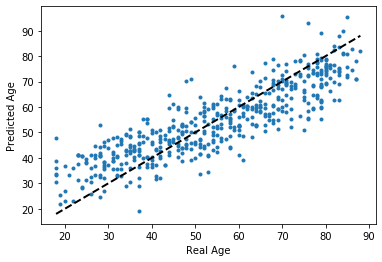

mean absolute error: 7.4092177285118215
r2 score: 0.7472579263378314


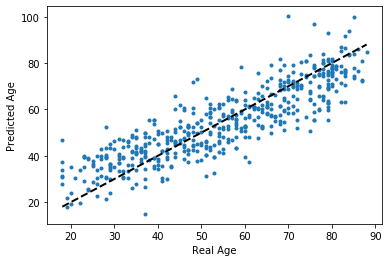

mean absolute error: 7.164284517441986
r2 score: 0.7628678642711573


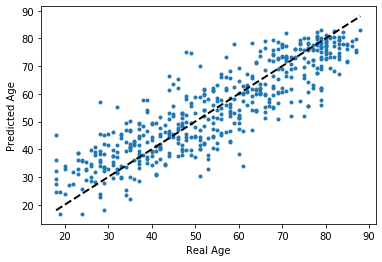

In [35]:
for i in range(3):
    plot_predicted_vs_real(y, predicted_of_models[:, i])

### Testing on 100 subjects

Load test volumes

In [36]:
test_vols, meta_data_reg_test = get_volumes(meta_file="meta_data_reg_test.csv")
test_vols_normalised = normalise_tissue_volumes(test_vols)

FileNotFoundError: ignored

Plot test tissue volumes

In [0]:
volume_scatter_plot(test_vols, meta_data_reg_test, title="Unnormalised")
volume_scatter_plot(test_vols_normalised, meta_data_reg_test, title="Normalised")

In [0]:
test_X = test_vols_normalised.T
test_y = meta_data_reg_test['age'].values.reshape(-1,1)

Fit model

In [0]:
model = clone(clfs[top_n_model_indexes[-1]], safe=True)
model.fit(X, y)

Evaluate model

In [0]:
test_predicted = model.predict(test_X)
plot_predicted_vs_real(test_y, test_predicted)

## Part B: PCA-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues. You may want to consider other ways of pre-processing and you can find insipiration in the notebook on medical image computing `02-Intro-Medical-Image-Computing.ipynb`.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation each time you run the notebook.

In [0]:
!mkdir data_new
!mkdir data_new/greymatter_gauss
!mkdir data_new/greymatter_diffusion

mkdir: cannot create directory ‘data_new’: File exists


In [0]:
# Definitions

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')

new_data_dir = 'data_new/'

In [0]:
# Generate smooth data and cache it

def smooth_data(meta):
    for i in range(len(meta['subject_id'])):
        
        print(i)

        ID = meta['subject_id'][i]

        gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
        gm = sitk.ReadImage(gm_filename)

        gm_gauss = sitk.DiscreteGaussian(gm, 1)
        gm_gauss_filename = new_data_dir + 'greymatter_gauss/wc1sub-' + ID + '_T1w.nii.gz'
        sitk.WriteImage(gm_gauss, gm_gauss_filename)

        gm_diffusion = sitk.GradientAnisotropicDiffusion(gm)
        gm_diffusion_filename = new_data_dir + 'greymatter_diffusion/wc1sub-' + ID + '_T1w.nii.gz'
        sitk.WriteImage(gm_diffusion, gm_diffusion_filename)
        
smooth_data(meta_data_reg_train)
smooth_data(meta_data_reg_test)

In [0]:
# Load data

def load_smoothed_data(meta, version):

    images = []

    for i in range(len(meta['subject_id'])):

        ID = meta['subject_id'][i]

        gm_filename = new_data_dir + f'greymatter_{version}/wc1sub-' + ID + '_T1w.nii.gz'
        images.append(sitk.GetArrayFromImage(sitk.ReadImage(gm_filename)).flatten())

    X = np.array(images)

    y = meta['age'].values.reshape(-1)
    
    return X, y

X_train_diffusion, y_train = load_smoothed_data(meta_data_reg_train, 'diffusion')
X_test_diffusion, y_test = load_smoothed_data(meta_data_reg_test, 'diffusion')


NameError: ignored

### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [0]:
########################################
# ADD YOUR CODE HERE
########################################

# All code for TASK B-2 and TASK B-3 is provided under TASK B-3

### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for your approach in Part A so results can be directly compared. Generate the similar plots.

Try using at least three different regression methods.

*Hint:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [0]:
# Model selection

import time

pipeline_caching_dir = 'pipeline_caching/'

# pca
from sklearn.decomposition import PCA

# regressors to choose from
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor 

# to combine in a single pipeline
from sklearn.pipeline import Pipeline

# for cross-validation
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('regr', 'passthrough')
], memory=pipeline_caching_dir)

pipe2 = LinearRegression()

param_grid = {
    'regr': [
        GradientBoostingRegressor(), 
        RandomForestRegressor(n_estimators=10), 
        LinearRegression(),
        KNeighborsRegressor()
    ]
}

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid, verbose=1, cv=2, scoring='neg_mean_absolute_error')

start_time = time.time()

_ = grid.fit(X_diffusion, y)

print("--- %s seconds ---" % (time.time() - start_time))

print(f'best score: {grid.best_score_}')
print(f'best params: {grid.best_params_}')


In [0]:
# Best model training

best_model = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('regr', LinearRegression())
])

start_time = time.time()

best_model.fit(X_train_diffusion, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

Error calculation and plotting

In [0]:
# Best model testing
from sklearn.metrics import mean_absolute_error, r2_score

y_test_pred = best_model.predict(X_test_diffusion)

print('mean absolute error: {0}'.format(mean_absolute_error(y_test_pred,y_test)))
print('r2 score: {0}'.format(r2_score(y_test_pred,y_test)))

fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pred, marker='.')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.savefig('test_result.pdf')

## Part C: CNN-based regression using grey matter maps

The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B.

*Note:* For part C, only the spatially normalised grey matter maps should be used. Similar to task A, you may want to set up a configuration for the CNN training that may also involve some resampling of the input data.

In [0]:
# Definitions

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')

new_data_dir = 'data_new/'

In [0]:
def gauss_downsample(img, factor=2):
    smoothed = sitk.DiscreteGaussian(img, (.5 * factor) ** 2)   
    return smoothed[::factor, ::factor, ::factor]

def diffusion_downsample(img, factor=2):
    smoothed = sitk.GradientAnisotropicDiffusion(img)
    return smoothed[::factor, ::factor, ::factor]

In [0]:
def smooth_data(meta):
    for i in range(len(meta['subject_id'])):
        
        print(i)

        ID = meta['subject_id'][i]

        gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
        gm = sitk.ReadImage(gm_filename)

        # gm_gauss = sitk.DiscreteGaussian(gm, 1)
        gm_gauss = gauss_downsample(gm, factor=3)

        gm_gauss_filename = new_data_dir + 'greymatter_gauss/wc1sub-' + ID + '_T1w.nii.gz'
        sitk.WriteImage(gm_gauss, gm_gauss_filename)

        # gm_diffusion = sitk.GradientAnisotropicDiffusion(gm)
        gm_diffusion = diffusion_downsample(gm, factor=2)
        gm_diffusion_filename = new_data_dir + 'greymatter_diffusion/wc1sub-' + ID + '_T1w.nii.gz'
        sitk.WriteImage(gm_diffusion, gm_diffusion_filename)
        
smooth_data(meta_data_reg_train)
smooth_data(meta_data_reg_test)

In [0]:
# Load data

def load_smoothed_data(meta, version):

    images = []

    for i in range(len(meta['subject_id'])):

        ID = meta['subject_id'][i]

        gm_filename = new_data_dir + f'greymatter_{version}/wc1sub-' + ID + '_T1w.nii.gz'
        images.append(sitk.GetArrayFromImage(sitk.ReadImage(gm_filename)).flatten())

    X = np.array(images)

    y = meta['age'].values.reshape(-1)
    
    return X, y

X_train_diffusion, y_train = load_smoothed_data(meta_data_reg_train, 'diffusion')
X_test_diffusion, y_test = load_smoothed_data(meta_data_reg_test, 'diffusion')


In [0]:
# class SimpleNet3D(nn.Module):

#     def __init__(self, num_classes):
#         super(SimpleNet3D, self).__init__()
#         self.conv1 = nn.Conv3d(1, 6, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv3d(6, 16, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv3d(16, 120, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv3d(120, 84, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv3d(84, num_classes, kernel_size=3, padding=1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.conv5(x)
#         return F.relu(x)

class AlexNet(nn.Module):

    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Conv3d(256, 4096, kernel_size=6),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv3d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(4096, 1, kernel_size=1),
        )

        self.reset_parameters()

    def reset_parameters(self):
        for weight in self.parameters():
            weight.data.uniform_(-0.1, 0.1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class NNAgeRegressionDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, ages, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            #pre=processing
            img = resample_image(img, img_spacing, img_size, is_label=False)

            sample = {'img': img, 'age': ages[idx]}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        age = sample['age']

        return {'img': image, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

In [0]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
train_img_ids = list(meta_data_reg_train['subject_id'])
train_ages = list(meta_data_reg_train['age'])

In [0]:
# dataset_train = NNAgeRegressionDataset(files_seg_img_train, img_spacing, img_size)
# dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# dataset_val = NNAgeRegressionDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
# dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

In [0]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=1)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice_test = 0
precision_test = 0
recall_test = 0

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)       
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.int64))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))

        ref = sample['seg']

        overlap_measures_filter.Execute(prediction, ref)
        dice_test += overlap_measures_filter.GetDiceCoefficient()
        print('+ TESTING \tCurrent DSC: ' + str(overlap_measures_filter.GetDiceCoefficient()) )

        predictions = sitk.GetArrayFromImage(prediction)
        predictions = predictions.reshape(-1,)

        refs = sitk.GetArrayFromImage(ref)
        refs = refs.reshape(-1,)

        precision_test += precision_score(predictions, refs)
        recall_test += recall_score(predictions, refs)

        idx_test += 1
        

loss_test /= sum_pts
dice_test /= idx_test
precision_test /= idx_test
recall_test /= idx_test

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
print('+ TESTING \tDSC: ' + str(dice_test)) 
print('+ TESTING \tPrecision: ' + str(precision_test))
print('+ TESTING \tRecall: ' + str(recall_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

Error calculation and plotting

In [0]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted)))
print('r2 score: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

In [0]:
print(sitk.ReadImage(gm_diffusion_filename))

Image (0x40398c0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 956215
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 956193
  UpdateMTime: 956214
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [90, 108, 90]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [90, 108, 90]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [90, 108, 90]
  Spacing: [2, 2, 2]
  Origin: [-89, -91, -71]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
2 0 0
0 2 0
0 0 2

  PointToIndexMatrix: 
0.5 0 0
0 0.5 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x4a7fd40)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 956211
      Debug:

652
